In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [134]:
# Preprocessing and Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [73]:
# Clustering algorithms
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn_extra.cluster import KMedoids

In [76]:
# Metrics for evaluation
from sklearn.metrics import mean_squared_error
from skimage import color
from skimage.metrics import structural_similarity as ssim

(-0.5, 1860.5, 2662.5, -0.5)

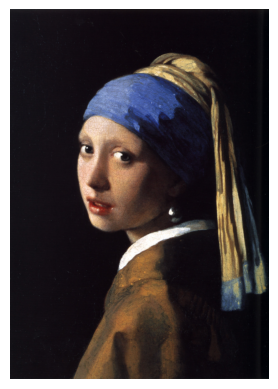

In [97]:
img = cv2.imread('./Paintings/Vermeer.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

##  Preprocesamiento de Datos

Para poder llevar a cabo la cuantización de colores, se llevará a cabo el siguiente preprocesamiento de los datos: 

**Reducción de Resolución**: Las imagenes, dependiendo de su resolución, pueden estar constituidas por una gran cantidad de píxeles para poder obtener una representación lo más suave, entiendase la dificultad para distinguir los píxeles entre sí, y de mayor calidad posible, lo que en materia de representación resulta muy útil, pero que para el ejercicio presente desarrolla un nuevo reto por el hecho de que una mayor cantidad de pixeles representa una mayor cantidad de valores similares a procesar. Esto, para aquellos algoritmos cuya complejidad espacial se acerque o supere $O(n^2)$, representa un desaf[io debido al alto consumo de memoria en el que se incurre. 

Para poder evitar esta situación, se llevará acabo el proceso de disminución de densidad de las imagenes, para aligerar el costo de procesamiento de los algoritmos y poder evitar o disminuir el consumo de recursos. 

**Flattening o Aplanamiento de la imagen**: Las imagenes son matrices multidimensionales de pixeles pertenecientes a un espacio de color, como puede ser RGB, normalmente en 3D para poder representar cada unode los diferentes colores. Sin embargo, algunos de los algoritmos empleados para cuantizar, como Kmeans o Kmedoids, esperan que se use como datos de entradas características representadas a través de arreglos en 2D, por lo que es necesario que se de un proceso de "aplanmiento" o cambio de forma en el arreglo de pixeles para que puedan emplearse, 


In [131]:
def reduce_res(image,h,w,p=0.8):
    # p es un valor entre 0 y 1, que determina la nueva dimension de la img
    nw = w*p

    nh = h*p
    reduced =  cv2.resize(image, (int(nw), int(nh)), interpolation=cv2.INTER_AREA)
    return (reduced,int(nh),int(nw))

(-0.5, 1487.5, 2129.5, -0.5)

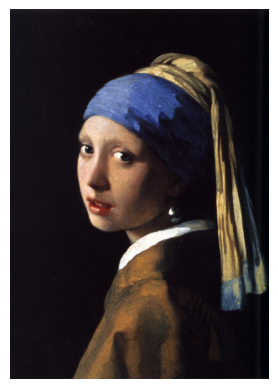

In [144]:
test = reduce_res(img,img.shape[0],img.shape[1])
plt.imshow(cv2.cvtColor(test[0], cv2.COLOR_BGR2RGB))
plt.axis("off")

In [122]:
# Function to flatten the image
def flatten_img(img,h,w):
    res =  np.reshape(img, ( (h*w),3 ))
    return res

# Function to return the image to its original form
def unflatten_img(img,h,w):
    res = img.reshape((h,w,3))
    return res

In [152]:
def pre_process(img,p=0.8):
    data ={}
    reduced = reduce_res(img,img.shape[0],img.shape[1],p)
    
    data['img'] = reduced[0]
    data['h'] = reduced[1]
    data['w'] = reduced[2]

    data['flat'] = flatten_img(data['img'],data['h'],data['w'])
    temp = std_img(data['flat'])
    return data

def postprocess(clusters,data):
    temp = np.reshape(clusters.astype("uint8")[data['labels']],(data['h'],data['w'], 3))
    data['res'] = temp

## Cuantización: KMeans

KMeans es un algoritmo de clustering, el cual al hacer el proceso de agrupación divide en k grupos los datos basandosé en la similitud entre ellos. 
Para esto K Means busca minimizar las distancias cuadradas entre cada elemento un su centroide, para luego asignar cada pixel al color más cercano, reduciendo de esta forma la paleta de colores

In [138]:
# definimos la paleta de colores máxima para la cuantización de colores
n_colors = 15
kmeans = KMeans(n_clusters=n_colors)
data = pre_process(img)

Debido a la posible alta cantidad de pixeles que podrían existir aún después de la reducción y dada la naturaleza sensible de K Means a su inicialización, el modelo primero se entrenará primero con un subset de pixeles representativos para poder reducir la carga computacional aún más y poder luego predecir la imagen completa. 

In [153]:
sample =  shuffle(data['flat'], random_state=0, n_samples=1_000)
kmeans.fit(sample)
# Entrenando el modelo en la imagen completa
data['labels'] = kmeans.predict(data['flat'])
postprocess(kmeans.cluster_centers_,data)

(-0.5, 1487.5, 2129.5, -0.5)

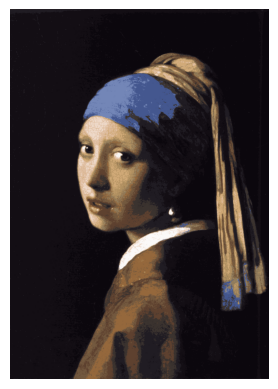

In [154]:
res_img = cv2.cvtColor(data['res'], cv2.COLOR_BGR2RGB)
plt.imshow(res_img)
plt.axis("off")

### Cuantización: KMedoids

In [ ]:
kmedoids = KMedoids(n_clusters=n_colors)
data = pre_process(img,0.05)
labels = kmedoids.fit(data['flat'])

In [166]:
labels.cluster_centers_

array([[21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.],
       [21., 15., 20.]])

### Cuantización: Hierarchical Clustering

## Evaluación de Resultados

Para evaluar los resultados de los algoritmos usados para la cunatización, se usarán 3 medidas, dos cuantitivas (MSE, SSIM) y una cualitativa (Delta-E). A continuación se brinda una breve explicación de cada una de ellas y el porqué de su uso: 

* MSE: Medida cuantitativa, la cual devolverá el la diferencia del promedio cuadrada de los pixeles entre ambas imágenes, evaluando de esta forma la diferencia entre los valores de los pixeles de ambas imágenes. Al ser meramente cuantitativa y basandosé solamente en similitudes, sus resultados pueden indicar que imágenes que no son tan similares al ojo humano son más similares a un nivel mátematico.
  
* SSIM: Es una medida cuantitativa conceptual, la cual evalúa los cambios y diferencias en contraste, ilumniación e información estructural, para modelar la forma en que precibimos las imágenes y su calidad, para dar una medición más robusta que MSE.

  
* Delta-E: Es una medida más cualitativa que las anteriores, ya que mide la de percepción entre dos colores en un espacio uniforme de color. En este caso, se usará el espacio de color CIELAB, que se diseño para aproximarse a la forma de visión humana y fuciona de la siguiente manera: *L* representa el grado de brillo de una imagen. en un rango de 0 a 100; *a* es el eje rojo-verde, donde valores positivos indican un mayor tono rojizo y valores negativos uno verde; *b* un indice azul-amarillo, siendo valores positivos más cercanos al amarillo y negativos al azul.



In [89]:
def delta_e(original, reduced):
    # Convert images to LAB color space
    lab_original = color.rgb2lab(original)
    lab_reduced = color.rgb2lab(reduced)
    
    # Compute the Delta-E (color difference)
    delta_e = color.deltaE_cie76(lab_original, lab_reduced)
    return np.mean(delta_e)  # Average color difference


In [78]:
def metrics(original,reduced):
    res = {}
    res['MSE'] = mean_squared_error(original_image.flatten(), quantized_image.flatten())
    res['SSIM'] = ssim(original,reduced,multichannel=True)
    res['Delta-E'] = delta_e(original,reduced)
    return res
    

In [88]:
def show_result(original,reduced,metrics):
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(reduced, cv2.COLOR_BGR2RGB))
    print(f" Resultado de MSE: {metrics['MSE']} \n Resultado de SSIM:{metrics['SSIM']} \n Resultado Delta-E: {metrics['Delta-E']}")